In [1]:
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from src.model import MLPdynamics, Transformerdynamics
from src.dataset_loader import F1TENTH_Dataset, F1TENTH_DataLoader

import hydra
from src.logger import Logger
import src.utils as utils
from tqdm import tqdm
import pandas as pd

/opt/anaconda3/envs/f110_rl_obs/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_single_csv_data(data_path_file):
    """
        the State has the following format:
                    'delta_time',
                    'pose_position_x',
                    'pose_position_y',
                    'yaw',
                    'body_vx',
                    'body_vy',
                    'yaw_rate',
                    'linear_acceleration_x',
                    'linear_acceleration_y',

        the action has the following format:
                        'cmd_st_angle',
                        'cmd_speed'
    """
    from src.dataset_loader import columns_to_read
    df = pd.read_csv(data_path_file)[columns_to_read]
    df['yaw'] = (df['yaw'] + np.pi) % (2 * np.pi) - np.pi
    df['delta_time'] *= 2
    df = df.drop(df.index[0]).to_numpy()

    return df


def open_loop_simulation_eval(model, data_path_file):
    data = read_single_csv_data(data_path_file)
    print(data.shape)

    start_idx = 50
    end_idx = 500

    points = []
    gts = []

    cur_states = data[start_idx - 3: start_idx + 1, :9].copy()
    actions = data[start_idx - 3: start_idx + 1, 9:].copy()

    for i in range(start_idx, end_idx):
        # pred_next state only has 5 columns
        pred_next_state = model(cur_states.reshape(1, -1, 9),
                                actions.reshape(1, -1, 2))
        points.append(pred_next_state)
        gts.append(data[i+1][1:6])

        next_state_b = data[i+1][:9].copy()
        next_state_b[1:6] = pred_next_state
        
        cur_states = np.vstack([cur_states[1:], next_state_b[:9]])
        actions = data[i-2: i+2, 9:]

    return np.array(points), np.array(gts)

In [3]:
model = lambda x, a: utils.single_track_dynamics(x, a, mode='3')

points, gts = open_loop_simulation_eval(model, '/Users/mac/Desktop/PENN/f1tenth-final-project/data/mergedf/final_4.csv')


(3704, 11)


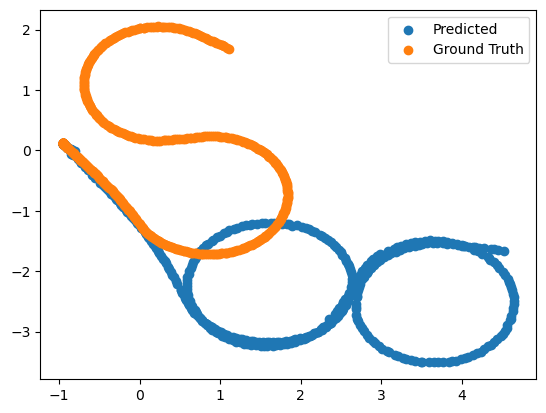

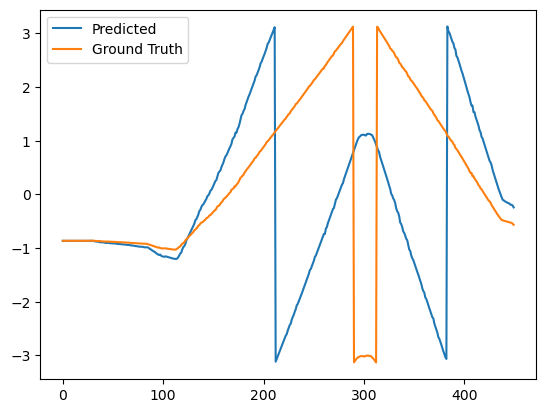

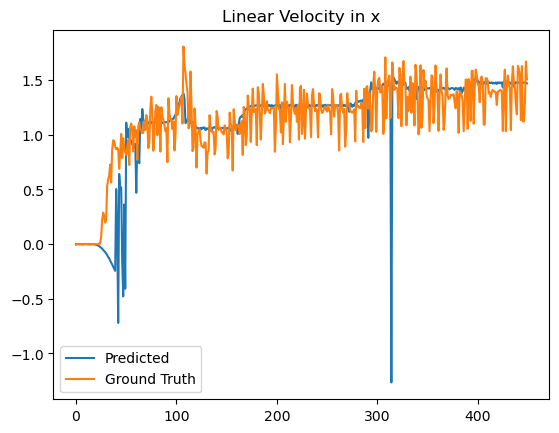

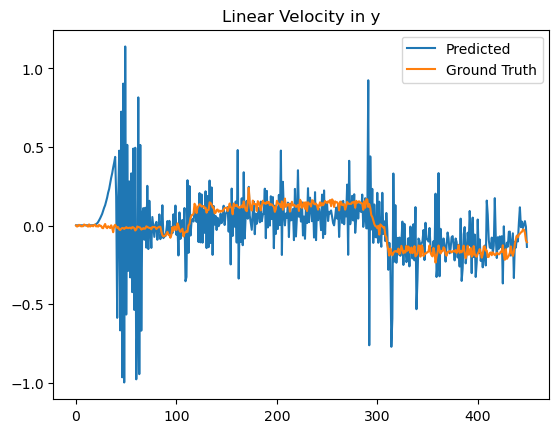

In [4]:
import matplotlib.pyplot as plt

# 1. Plot the predicted trajectory and the ground truth trajectory
fig, ax = plt.subplots()
ax.scatter(points[:, 0], points[:, 1], label='Predicted')
ax.scatter(gts[:, 0], gts[:, 1], label='Ground Truth')
plt.legend()
plt.show()

# 2. plot yaw
fig, ax = plt.subplots()
ax.plot(points[:, 2], label='Predicted')
ax.plot(gts[:, 2], label='Ground Truth')
plt.legend()
plt.show()

# 3. plot linear velocity
fig, ax = plt.subplots()
ax.plot(points[:, 3], label='Predicted')
ax.plot(gts[:, 3], label='Ground Truth')
plt.legend()
plt.title('Linear Velocity in x')
plt.show()

# 4. plot linear velocity y
fig, ax = plt.subplots()
ax.plot(points[:, 4], label='Predicted')
ax.plot(gts[:, 4], label='Ground Truth')
plt.legend()
plt.title('Linear Velocity in y')
plt.show()


In [5]:
import torch

model = torch.load('/Users/mac/Desktop/PENN/f1tenth-final-project/outputs/2024-05-07/15-07-20/checkpoints/mlp_model_2266.pth')

In [6]:
def world2local(states):
    states = states.clone()
    states[:, :, 1:4] = states[:, :, 1:4] - states[:, 0:1, 1:4]
    return states

def local2world(old_state, states):
    states = states.clone()
    states[:, :, 0:3] = states[:, :, 0:3] + old_state[:, 0:1, 1:4]
    return states


def open_loop_simulation_eval_nn(data_path_file):
    #data_path_file = 'data/data_mu10/state_list_4.csv'
    #data_path_file = '/Users/mac/Desktop/PENN/f1tenth-final-project/data/mergedf/final_4.csv'
    data = read_single_csv_data(data_path_file)
    print(data.shape)

    start_idx = 50
    end_idx = 500

    points = []
    gts = []

    cur_states = data[start_idx - 3: start_idx + 1, :9].copy()
    actions = data[start_idx - 3: start_idx + 1, 9:].copy()

    cur_states = torch.tensor(cur_states, dtype=torch.float32).unsqueeze(0)
    actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(0)


    for i in range(start_idx, end_idx):
        # pred_next state only has 5 columns

        _cur_states = world2local(cur_states)
        pred_next_state = model(_cur_states,
                                actions)

        pred_next_state_ = local2world(cur_states, pred_next_state.unsqueeze(1)).squeeze()
        points.append(pred_next_state_.detach().numpy())
        gts.append(data[i+1][1:6])

        next_state_b = torch.tensor(data[i+1][:9], dtype=torch.float32)
        next_state_b[1:6] = pred_next_state_
        
        cur_states = torch.cat([cur_states[:, 1:], next_state_b[:9].unsqueeze(0).unsqueeze(0)], dim=1)
        actions = torch.tensor(data[i-2: i+2, 9:], dtype=torch.float32).unsqueeze(0)

    return np.array(points), np.array(gts)

In [8]:
def plot_pred_gt(points, gts):
    fig, ax = plt.subplots()
    ax.scatter(points[:, 0], points[:, 1], label='Predicted')
    ax.scatter(gts[:, 0], gts[:, 1], label='Ground Truth')
    plt.legend()
    plt.show()

    # 2. plot yaw
    fig, ax = plt.subplots()
    points[:, 2] = (points[:, 2] + np.pi) % (2 * np.pi) - np.pi
    ax.plot(points[:, 2], label='Predicted')
    ax.plot(gts[:, 2], label='Ground Truth')
    plt.legend()
    plt.show()

    # 3. plot linear velocity
    fig, ax = plt.subplots()
    ax.plot(points[:, 3], label='Predicted')
    ax.plot(gts[:, 3], label='Ground Truth')
    plt.legend()
    plt.title('Linear Velocity in x')
    plt.show()

    # 4. plot linear velocity y
    fig, ax = plt.subplots()
    ax.plot(points[:, 4], label='Predicted')
    ax.plot(gts[:, 4], label='Ground Truth')
    plt.legend()
    plt.title('Linear Velocity in y')
    plt.show()

In [21]:
#data_path_file = 'data/data_mu10/state_list_4.csv'
data_path_file = '/Users/mac/Desktop/PENN/f1tenth-final-project/data/mergedf/final_4.csv'
data = read_single_csv_data(data_path_file)
print(data.shape)

start_idx = 50
end_idx = 3000

points = []
gts = []

cur_states = data[start_idx - 3: start_idx + 1, :9].copy()
actions = data[start_idx - 3: start_idx + 1, 9:].copy()

cur_states = torch.tensor(cur_states, dtype=torch.float32).unsqueeze(0)
actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(0)


pred_next = []

import time
start = time.time()
for i in range(start_idx, end_idx):
    # pred_next state only has 5 columns

    _cur_states = world2local(cur_states)
    pred_next_state = model(_cur_states,
                            actions)

    pred_next_state_ = local2world(cur_states, pred_next_state.unsqueeze(1)).squeeze()
    points.append(pred_next_state_.detach().numpy())
    gts.append(data[i+1][1:6])

    pred_next.append(pred_next_state.detach().numpy())

    #next_state_b = torch.tensor(data[i+1][:9], dtype=torch.float32)
    #next_state_b[1:6] = pred_next_state_
    
    #cur_states = torch.cat([cur_states[:, 1:], next_state_b[:9].unsqueeze(0).unsqueeze(0)], dim=1)
    cur_states = torch.tensor(data[i-2: i+2, :9], dtype=torch.float32).unsqueeze(0)
    cur_states[:, :, 1:6] = pred_next_state_.unsqueeze(0)


    actions = torch.tensor(data[i-2: i+2, 9:], dtype=torch.float32).unsqueeze(0)

end = time.time()
print(end - start)
print(len(points))
print("Frequency: ", 3000/(end - start), "Hz")

points, gts = np.array(points), np.array(gts)
pred_next = np.array(pred_next)

(3704, 11)
0.8037371635437012
2950
Frequency:  3732.563499705439 Hz


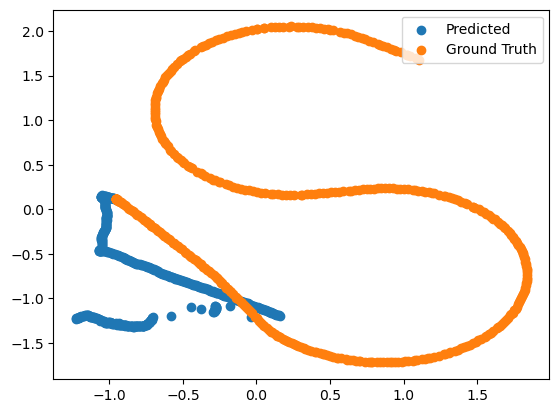

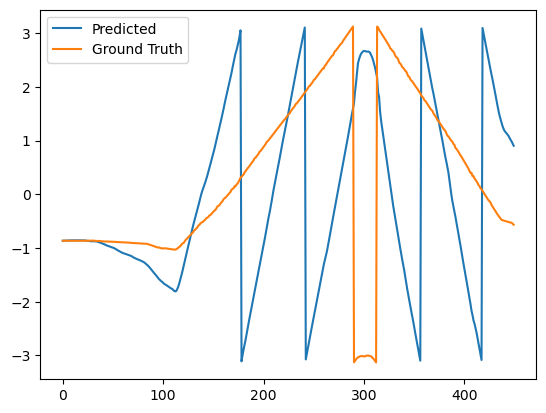

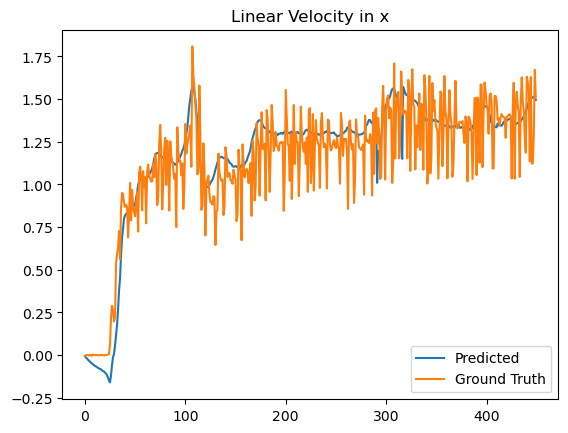

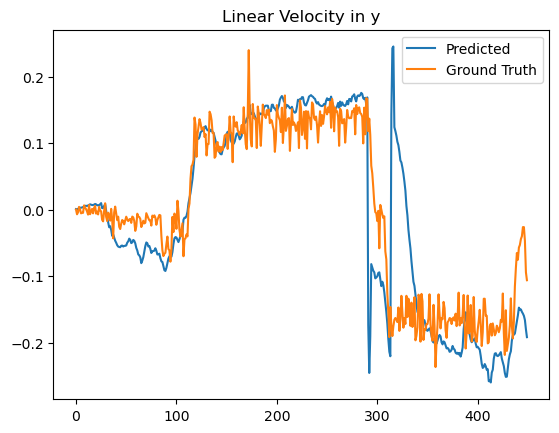

In [11]:
plot_pred_gt(points, gts)

(3704, 11)


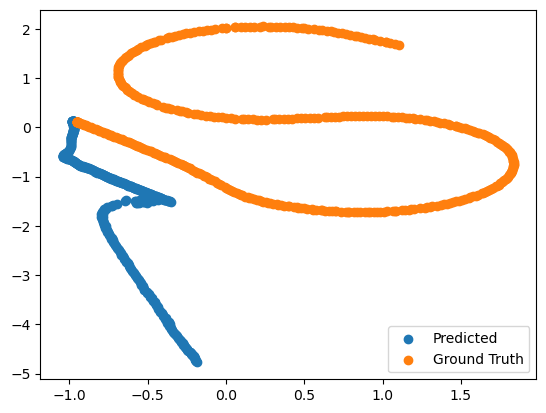

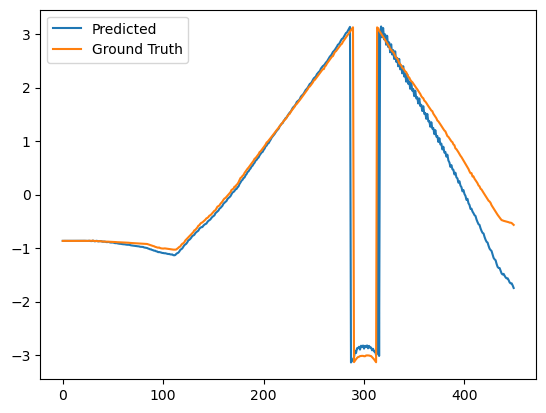

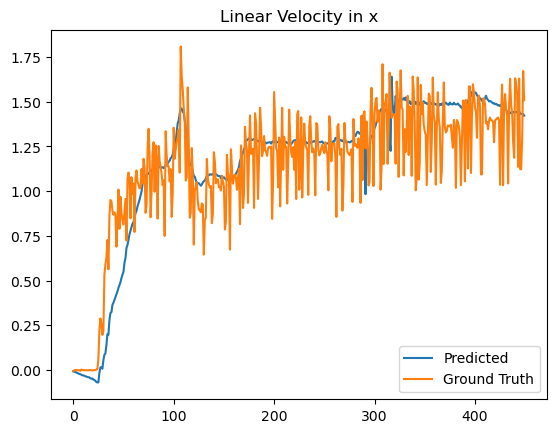

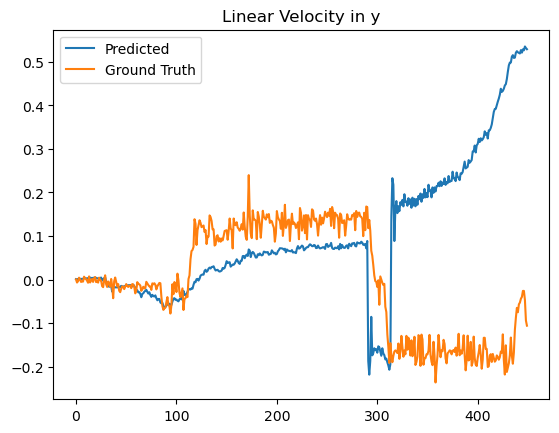

In [56]:
d_path = '/Users/mac/Desktop/PENN/f1tenth-final-project/data/mergedf/final_4.csv'
points, gts = open_loop_simulation_eval_nn(d_path)

plot_pred_gt(points, gts)

In [20]:
pred_next.sum(axis=0)

array([[-2.7286080e-01, -1.3410553e+00,  1.7698048e+00,  5.2901221e+02,
        -3.4709311e+00]], dtype=float32)

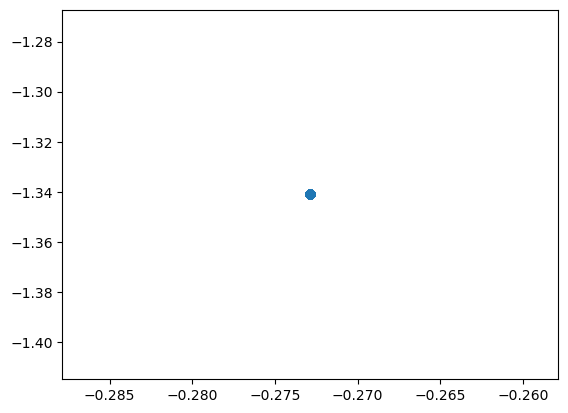

In [18]:
#i = np.linspace(0, 100, len(pred_next))
#plt.plot(i, pred_next[:, 0, 0], label='delta_x')
#plt.plot(i, pred_next[:, 0, 1], label='delta_y')
#plt.legend()
#plt.show()

pths = []
origin = np.array([0.0, 0.0])
pths.append(origin)
for i in range(len(pred_next)):
    origin += pred_next[i][0, :2]
    pths.append(origin)

pths = np.array(pths)
plt.scatter(pths[:, 0], pths[:, 1])

plt.show()




(3641, 11)


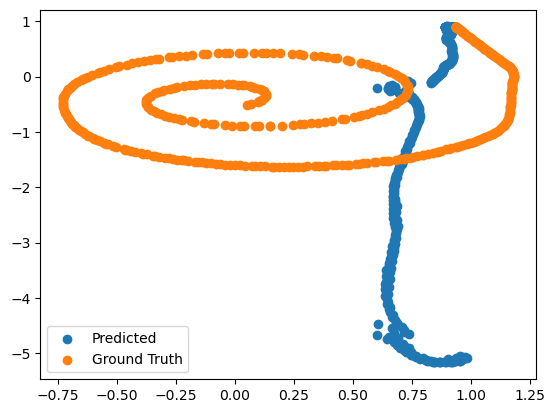

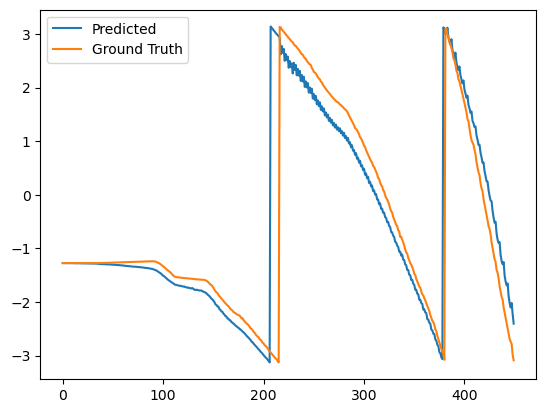

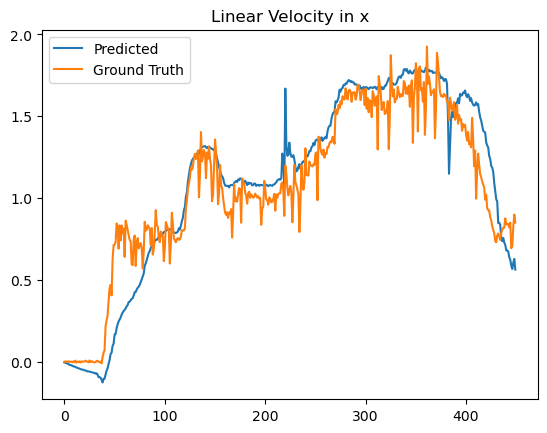

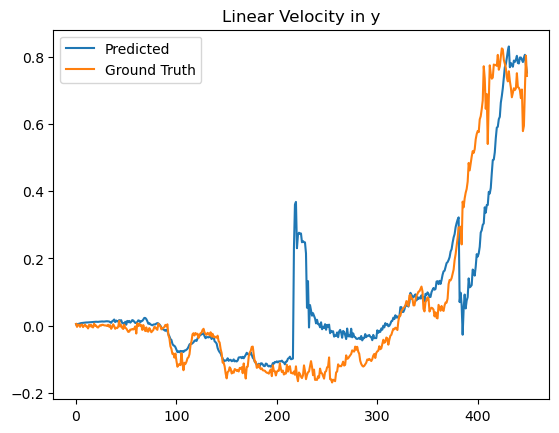

(3641, 11)


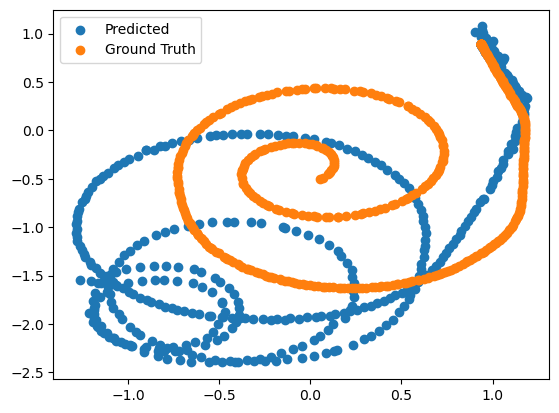

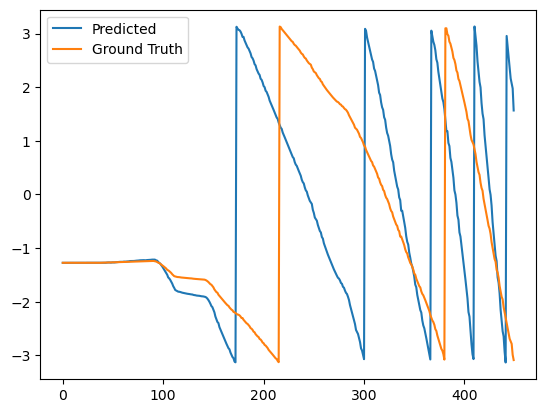

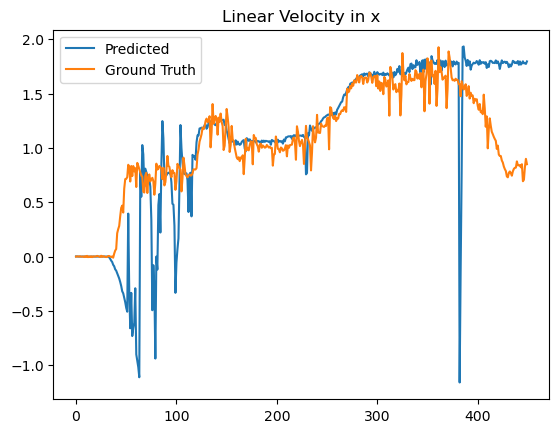

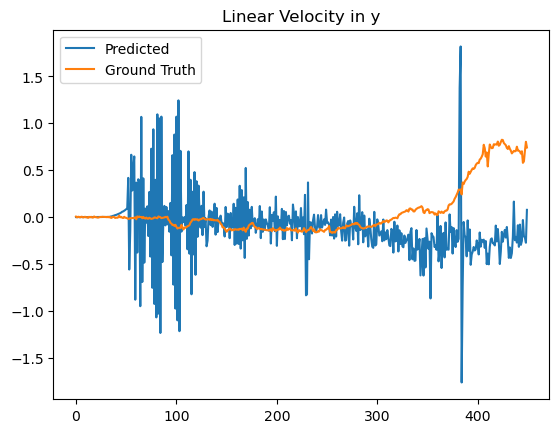

In [53]:
points, gts = open_loop_simulation_eval_nn('/Users/mac/Desktop/PENN/f1tenth-final-project/data/mergedf/final_rear03.csv')

plot_pred_gt(points, gts)

dyna = lambda x, a: utils.single_track_dynamics(x, a, mode='3')
points, gts = open_loop_simulation_eval(dyna, '/Users/mac/Desktop/PENN/f1tenth-final-project/data/mergedf/final_rear03.csv')

plot_pred_gt(points, gts)